# Velocity on monocytes per patient

In [2]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import os
from glob import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

## Load adata and start from here

In [ ]:
out_loom = "/covid/scvelo/velocity_h5/comb_all.loom"
adata = scv.read_loom(out_loom)
adata.obs.cell_type_major = adata.obs.cell_type_major.astype('category')
adata.obs['donor_time_run'] = adata.obs[['donor', 'timepoint', 'run']].agg('_'.join, axis=1)

In [11]:
# Split adata to multiple subsets based on patient-timepoint
adata_split = {x : adata[adata.obs.donor_time_run == x,:] for x in adata.obs.donor_time_run.unique()}

## Processing and velocity

In [14]:
def processor(adata, pattern, outpath):
    # Pre
    name = adata.obs.donor_time_run.unique()[0]
    adata = adata[adata.obs.cell_type_major_low.str.contains(pattern),:]

    # introduce features
    sc.pp.filter_cells(adata, min_genes=1)
    sc.pp.filter_genes(adata, min_cells=1)
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1

    mito_genes = adata.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1

    scv.pp.filter_genes(adata, min_cells=10**0)
    adata = adata[adata.obs['n_genes'] < 5000, :]
    adata = adata[adata.obs['percent_mito'] < 0.15, :]

    scv.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    scv.pp.log1p(adata)

    scv.pp.filter_genes_dispersion(adata, min_mean=0.0125, max_mean=5, min_disp=0.5)
    sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    
    sc.pp.scale(adata, max_value=10)

    scv.pp.moments(adata, n_pcs=40, n_neighbors=10)
    scv.pp.neighbors(adata)
    scv.tl.umap(adata)


    # Velocity
    scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata, n_recurse_neighbors=2)
    scv.tl.velocity_embedding(adata, basis='umap')
    scv.tl.terminal_states(adata)
    
    adata.write(os.path.join(outpath, name+".h5ad"))
    
    return adata

In [ ]:
adata_clean = {x : processor(adata_split[x], pattern="ono", outpath='/covid/scvelo/velocity_h5') for x in adata_split}

In [ ]:
# import test

In [4]:
filelist = glob('/covid/scvelo/velocity_h5/*')

In [5]:
filelist

['/covid/scvelo/velocity_h5/ICC_C_0001_None_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1005_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1003_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1017_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1007_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/ICC_C_0005_None_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/ICC_C_0004_None_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1014_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1001_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1009_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1025_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/Rep_C_1015_0_200423_run1.h5ad',
 '/covid/scvelo/velocity_h5/ICC_C_0003_None_200423_run1.h5ad']

In [6]:
adata_clean = {x : scv.read(x) for x in filelist}

# Plan per patient  
1. Fit dynamic model  
2. Fit likelihood  
3. Get top likelihood genes  
4. Get top velocity genes  
5. Get differential kinetics  
6. FET top diff kinetic and top likelihood genes for healthy/disease  
7. Heatmap stacked top likelihood genes per patient sorted by a common gene set  
8. Velocity length and confidence - to violin plot

In [16]:
scv.set_figure_params(dpi=100, dpi_save=100, format='svg', frameon=False, transparent=True, fontsize=10)
figdir = "covid19/tests/figures"

In [ ]:
# emedding and plot
[scv.pl.velocity_embedding_stream(adata_clean[x], basis='umap', color='cell_type_major_low', title=x, show=False,
                                 save='embed_'+os.path.basename(x).split(".")[0]+'.png') for x in adata_clean]

In [ ]:
# top velocity genes
[scv.tl.rank_dynamical_genes(adata_clean[x], groupby='cell_type_major_low') for x in adata_clean]
top_velo = {x: scv.get_df(adata_clean[x], 'rank_dynamical_genes/names') for x in adata_clean}


In [28]:
# top likelihood genes
top_lkl = {x: adata_clean[x].var['fit_likelihood'].sort_values(ascending=False).index for x in adata_clean}

In [ ]:
# latent time
[scv.tl.latent_time(adata_clean[x]) for x in adata_clean]
[scv.pl.scatter(adata_clean[x], color='latent_time', color_map='gnuplot', size=80, title=x, show=False,
                                 save='latent_'+os.path.basename(x).split(".")[0]+'.png') for x in adata_clean]

In [40]:
scv.set_figure_params(dpi=100, dpi_save=200, format='png', frameon=False, transparent=True, fontsize=5)

top_genes = {x : adata_clean[x].var['fit_likelihood'].sort_values(ascending=False).index[:300] for x in adata_clean}
[scv.pl.heatmap(adata_clean[x], var_names=top_genes[x], sortby='latent_time', col_color='cell_type_major_low', n_convolve=100,
               show=False, save='heatmap_'+os.path.basename(x).split(".")[0]+'.png') for x in adata_clean]

saving figure to file ./figures/scvelo_heatmap_heatmap_ICC_C_0001_None_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1005_0_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1003_0_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1017_0_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1007_0_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_ICC_C_0005_None_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_ICC_C_0004_None_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1014_0_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1001_0_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1009_0_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1025_0_200423_run1.png
saving figure to file ./figures/scvelo_heatmap_heatmap_Rep_C_1015_0

In [41]:
[scv.tl.velocity_confidence(adata_clean[x]) for x in adata_clean]
keys = 'velocity_length', 'velocity_confidence'
#[scv.pl.scatter(adata_clean[x], c=keys, cmap='coolwarm', perc=[5, 95])for x in adata_clean]


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (ada

In [104]:
df = {x: adata_clean[x].obs.groupby('cell_type_major_low')[keys].mean().T for x in adata_clean}

In [105]:
def df_transformer(df, name):
    df.columns = df.columns.tolist()
    df['donor_time_run'] = name
    df.reset_index(inplace=True)
    return df

In [106]:
df_clean = {x : df_transformer(df[x], os.path.basename(x).split(".")[0]) for x in df}

In [107]:
df_fin = pd.concat(df_clean, ignore_index=True).rename(columns={"index": "feature"})

In [89]:
refdata = sc.read("/covid/count_mat/run12345_combi_final2.h5ad")

In [91]:
refdata.obs['donor_time_run'] = refdata.obs[['donor', 'timepoint', 'run']].agg('_'.join, axis=1)

In [108]:
df_fin = df_fin.merge(refdata.obs[['donor_time_run', "COVID_status"]], on='donor_time_run', how="left")

In [112]:
df_fin_len = df_fin[df_fin.feature == "velocity_length"].drop_duplicates()
df_fin_conf = df_fin[df_fin.feature == "velocity_confidence"].drop_duplicates()

In [113]:
df_fin_len

feature      cMono     ncMono               donor_time_run  \
0       velocity_length   9.671056  10.761975  ICC_C_0001_None_200423_run1   
24422   velocity_length  12.090669  12.517750     Rep_C_1005_0_200423_run1   
35066   velocity_length   6.331365   7.034138     Rep_C_1003_0_200423_run1   
44588   velocity_length   3.364762   3.808750     Rep_C_1017_0_200423_run1   
50946   velocity_length  21.821045  15.004390     Rep_C_1007_0_200423_run1   
55736   velocity_length  11.538881   9.331250  ICC_C_0005_None_200423_run1   
61642   velocity_length   6.221770   6.486784  ICC_C_0004_None_200423_run1   
73642   velocity_length  16.143893  14.754286     Rep_C_1014_0_200423_run1   
82154   velocity_length   8.689116   5.891250     Rep_C_1001_0_200423_run1   
95170   velocity_length  10.729521  10.835192     Rep_C_1009_0_200423_run1   
103424  velocity_length   3.430519   3.661695     Rep_C_1025_0_200423_run1   
111066  velocity_length   3.703289   3.622609     Rep_C_1015_0_200423_run1   
120386  velocity_length   4.109118   3.683762  ICC_C_0003_None_200423_run1   

       COVID_status  
0              None  
24422      Positive  
35066      Positive  
44588      Negative  
50946      Positive  
55736          None  
61642          None  
73642      Positive  
82154      Positive  
95170      Negative  
103424     Positive  
111066     Positive  
120386         None

In [119]:
long = df_fin_len.drop(['feature', 'donor_time_run'], axis=1).melt(id_vars="COVID_status")

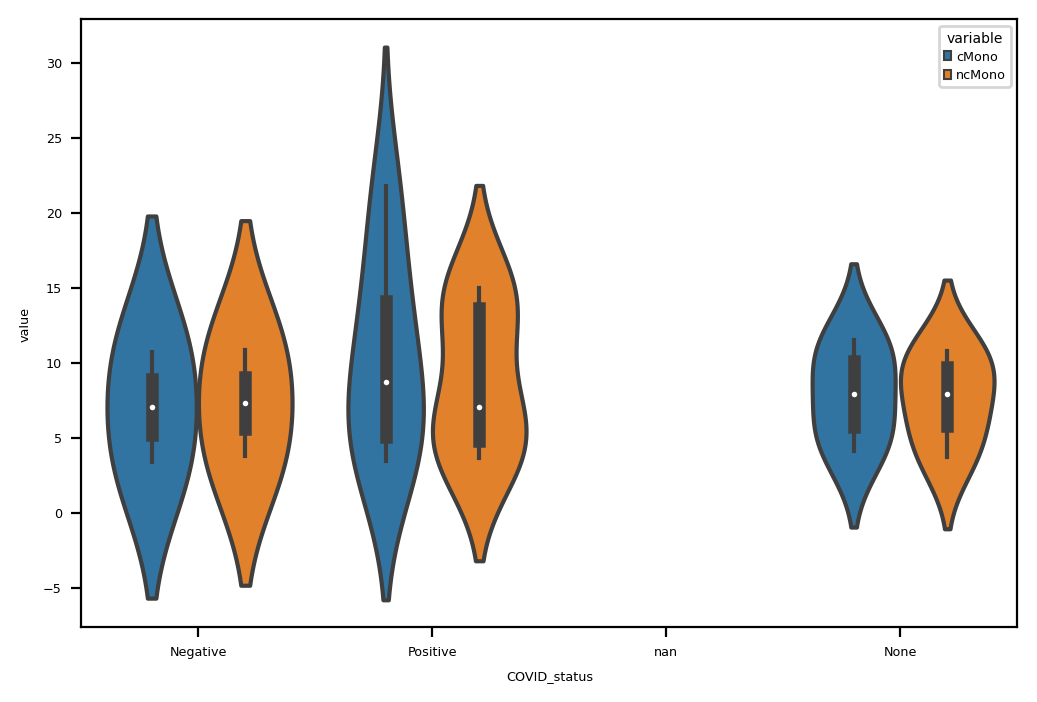

In [122]:
sns.violinplot(x='COVID_status', y='value', hue='variable', data=long, title="Velocity lenght")

In [123]:
long = df_fin_conf.drop(['feature', 'donor_time_run'], axis=1).melt(id_vars="COVID_status")

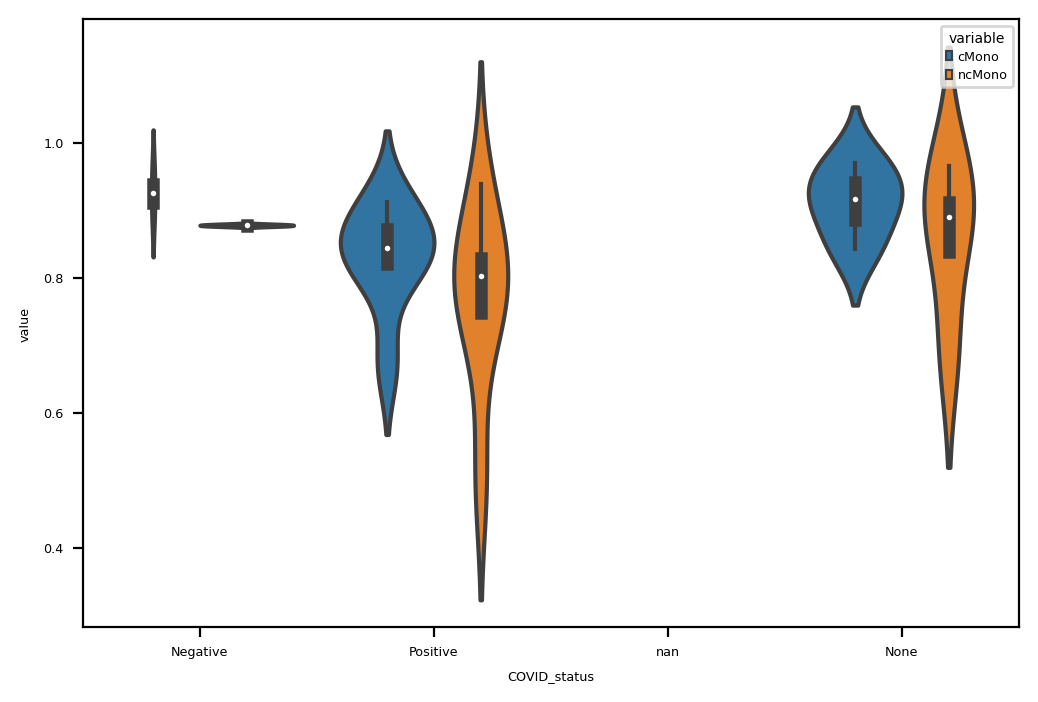

In [124]:
sns.violinplot(x='COVID_status', y='value', hue='variable', data=long, title="Velocity lenght")